In [1]:
%matplotlib inline

import numpy as np
import nibabel as nb
import pandas as pd
import sklearn
import pylab as plt
import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiMapsMasker, NiftiLabelsMasker

import os

In [2]:
def pred_real_scatter(y_test, y_test_predicted):
    plt.scatter(y_test, y_test_predicted)
    plt.plot([10,80],[10,80], 'k')
    plt.xlabel('real')
    plt.ylabel('predicted')
    ax = plt.gca()
    ax.set_aspect('equal')

# load and preprocess data

In [3]:
brain_mask_file = '/Users/franzliem/Dropbox/Workspace/LeiCA/anat_templates/\
cpac_image_resources/MNI_3mm/MNI152_T1_3mm_brain_mask.nii.gz'
brain_data_file_template = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/%s_merge.nii.gz'
df_file = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/df_used.csv'
subject_list = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/subject_list.txt'
metrics_list = ['alff', 'reho']

df = pd.read_csv(df_file, dtype='object')
df = df.set_index(df.subject_id)

s = pd.read_csv(subject_list, header=None, dtype=object)
s.columns=['subject_id']
assert np.all(s.subject_id == df.subject_id), "df not in right order"

#nilearn

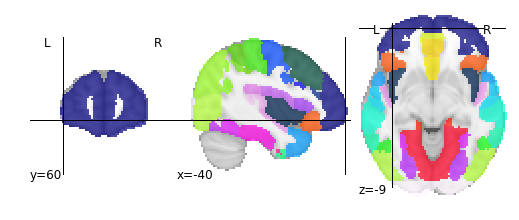

In [4]:
from nilearn import plotting, input_data, masking, signal, datasets
from nilearn.input_data import NiftiLabelsMasker

atlas_img, labels = datasets.fetch_harvard_oxford('cort-maxprob-thr25-2mm')
plotting.plot_roi(atlas_img,cut_coords=(-40,60,-9))

masker = NiftiLabelsMasker(labels_img=atlas_img)

## MSDL ATLAS

In [5]:
from nilearn import datasets
atlas = datasets.fetch_msdl_atlas()
atlas_img = atlas['maps']
import pandas
labels = pandas.read_csv(atlas['labels'])['name']

from nilearn.input_data import NiftiMapsMasker

masker = NiftiMapsMasker(maps_img=atlas_img)

## CRADDOCK ATLAS

In [6]:
from nilearn import datasets

parc_to_use=42
atlas_str = 'scorr_mean'

atlas = datasets.fetch_craddock_2012_atlas()
cc_file = atlas[atlas_str]
cc_folder = os.path.split(cc_file)[0]

cc_4d_img = nb.load(cc_file)
cc_4d_data = cc_4d_img.get_data()
n_resolution = cc_4d_data.shape[-1]
n_parcels = [np.unique(cc_4d_data[:,:,:,i]).shape[0]-1 for i in range(n_resolution)] # -1 to account for 0 background 
print 'using %s parcels'%n_parcels[parc_to_use]

#save 3d nii of desired parc.resolution
cc_3d_filename = os.path.join(cc_folder, atlas_str + '_parc_%s_%s_rois.nii.gz'%(parc_to_use,n_parcels[parc_to_use]))
cc_3d_img = nb.Nifti1Image(cc_4d_data[:,:,:,parc_to_use], cc_4d_img.get_affine(), cc_4d_img.get_header())
cc_3d_img.to_filename(cc_3d_filename)
print 'save to %s'%cc_3d_filename

using 788 parcels
save to /Users/franzliem/nilearn_data/craddock_2012/scorr_mean_parc_42_788_rois.nii.gz


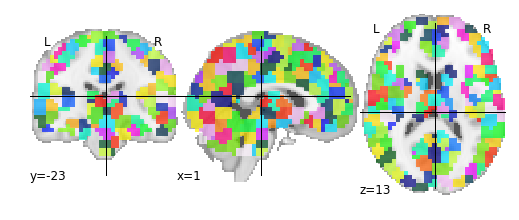

In [7]:
plotting.plot_roi(cc_3d_filename)
masker = NiftiLabelsMasker(labels_img=cc_3d_filename)

## extract roi data

In [64]:
roi_data = masker.fit_transform('/Users/franzliem/Dropbox/LeiCA/00_learning_test/%s_merge.nii.gz'%'falff')
roi_data.shape

(257, 788)

## test correlations

<Container object of 788 artists>

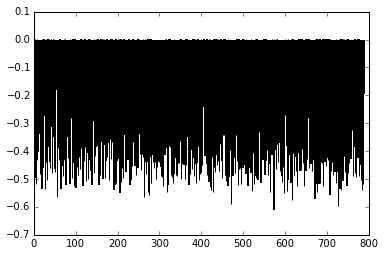

In [65]:
age = df.age.values.astype(np.float)
r_mat = np.corrcoef(age.T, roi_data.T)
r = r_mat[0,1:]
plt.bar(range(len(r)),r)

# preprocessing

In [66]:
X = roi_data
y = df.age.values.astype(np.float)

In [67]:
from sklearn.preprocessing import normalize
X_norm = normalize(X)

## women only

In [68]:
y = y[(df.sex=='F').values].astype(np.float)
X = X[(df.sex=='F').values,:]

print X.shape, y.shape

(166, 788) (166,)


## try SVR with CV

CV scores:
min: 0.474, mean: 0.528, max: 0.556
CPU times: user 642 ms, sys: 72.9 ms, total: 715 ms
Wall time: 886 ms


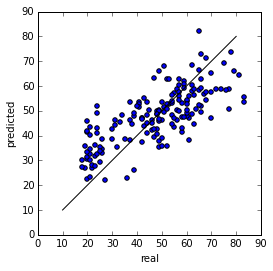

In [69]:
%%time
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = SVR(kernel='linear', epsilon=8, C=18) #, C=.006, epsilon=14){'epsilon'=8, C=0.001},
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='r2')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

NotFittedError: This SVR instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

CV scores:
min: 0.537, mean: 0.591, max: 0.667
CPU times: user 3.05 s, sys: 672 ms, total: 3.72 s
Wall time: 3.9 s


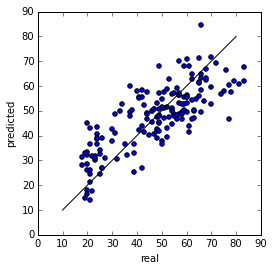

In [31]:
%%time

roi_data = masker.fit_transform('/Users/franzliem/Dropbox/LeiCA/00_learning_test/%s_merge.nii.gz'%'alff')
X = roi_data
X = X[(df.sex=='F').values,:]
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = SVR(kernel='linear', epsilon=7, C=.001) #, C=.006, epsilon=14){'epsilon'=8, C=0.001},
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='r2')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted_alff = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted_alff)

0.62006278287892624

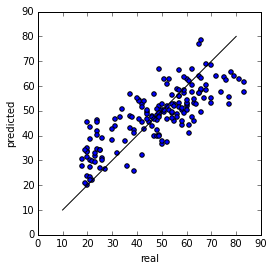

In [48]:
y_mean = (y_predicted + y_predicted_alff)/2
pred_real_scatter(y, y_mean)
sklearn.metrics.r2_score(y,y_mean)

#RFECV

In [ ]:
%%time
from sklearn.feature_selection import RFECV

regression_model = SVR(kernel='linear')
rfecv = RFECV(estimator=regression_model, step=100, cv=5, scoring='mean_absolute_error')

rfecv.fit(X, y)


In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

In [ ]:
print labels[rfecv.support_]


## USE GS

In [28]:
%%time

from sklearn.grid_search import GridSearchCV
regression_model = SVR(kernel='linear')
params = {
    'C': np.arange(10,24, 2), #[13,17], #np.arange(0.0025,.0065,.0001),
    'epsilon': np.arange(1,10, 1),
}
gs = GridSearchCV(regression_model, params, cv=5, scoring='r2', n_jobs=4)
gs.fit(X, y)

CPU times: user 1.32 s, sys: 364 ms, total: 1.68 s
Wall time: 2.49 s


In [27]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: 0.52866, std: 0.02940, params: {'epsilon': 8, 'C': 18},
 mean: 0.52785, std: 0.02875, params: {'epsilon': 7, 'C': 18},
 mean: 0.52626, std: 0.02593, params: {'epsilon': 8, 'C': 16},
 mean: 0.52623, std: 0.03052, params: {'epsilon': 9, 'C': 18},
 mean: 0.52529, std: 0.02515, params: {'epsilon': 7, 'C': 16},
 mean: 0.52451, std: 0.03050, params: {'epsilon': 6, 'C': 18},
 mean: 0.52444, std: 0.02816, params: {'epsilon': 9, 'C': 16},
 mean: 0.52327, std: 0.02084, params: {'epsilon': 8, 'C': 14},
 mean: 0.52223, std: 0.02713, params: {'epsilon': 6, 'C': 16},
 mean: 0.52153, std: 0.02396, params: {'epsilon': 9, 'C': 14},
 mean: 0.52117, std: 0.02330, params: {'epsilon': 6, 'C': 14},
 mean: 0.52100, std: 0.02128, params: {'epsilon': 7, 'C': 14},
 mean: 0.52020, std: 0.02514, params: {'epsilon': 5, 'C': 14},
 mean: 0.52020, std: 0.02881, params: {'epsilon': 4, 'C': 16},
 mean: 0.52013, std: 0.03337, params: {'epsilon': 5, 'C': 18},
 mean: 0.51958, std: 0.02589, params: {'epsilon': 4, 'C

[mean: -8.89690, std: 1.08884, params: {'C': 8e-05},
 mean: -8.84479, std: 1.13068, params: {'C': 9e-05},
 mean: -8.80590, std: 1.15327, params: {'C': 0.0001},
 mean: -8.70266, std: 1.15750, params: {'C': 0.0002},
 mean: -9.04828, std: 1.09990, params: {'C': 0.0005},
 mean: -9.15222, std: 1.22136, params: {'C': 0.0009},
 mean: -9.14406, std: 1.23476, params: {'C': 0.001}]

##GradientBoostingRegressor

In [ ]:
GradientBoostingRegressor?

CV scores:
min: 0.159, mean: 0.370, max: 0.473
CPU times: user 490 ms, sys: 94.2 ms, total: 584 ms
Wall time: 9.65 s


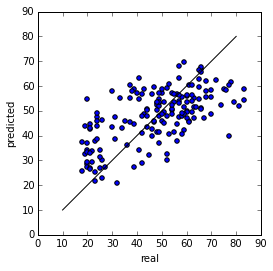

In [107]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = GradientBoostingRegressor()
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='r2')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

###GS

In [108]:
%%time

from sklearn.grid_search import GridSearchCV
regression_model = GradientBoostingRegressor()
params = {
    'max_depth': range(1,10,2),
    #'n_estimators': [50,100,1000]
}
gs = GridSearchCV(regression_model, params, cv=5, scoring='r2', n_jobs=4)
gs.fit(X, y)

CPU times: user 932 ms, sys: 71.4 ms, total: 1 s
Wall time: 38.3 s


In [109]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: 0.43261, std: 0.07527, params: {'max_depth': 1},
 mean: 0.38485, std: 0.11054, params: {'max_depth': 3},
 mean: 0.28336, std: 0.06852, params: {'max_depth': 5},
 mean: 0.09506, std: 0.08327, params: {'max_depth': 7},
 mean: -0.04644, std: 0.23091, params: {'max_depth': 9}]

In [ ]:
range(1,10,1)

## split

11.51945112
0.418466233758


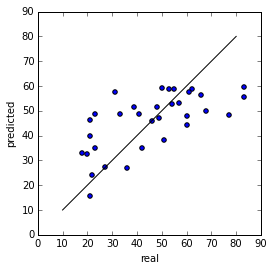

In [61]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regression_model = SVR(kernel='linear')
regression_model.fit(X_train,y_train)
y_test_predicted = regression_model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_predicted)
r2 = r2_score(y_test, y_test_predicted)

print mae
print r2
pred_real_scatter(y_test, y_test_predicted)

In [ ]:
coef_img = masker.inverse_transform(regression_model.coef_)
coef_img.to_filename('/Users/franzliem/Dropbox/LeiCA/00_learning_test/split_coeff_ROIs.nii.gz')

##LASSO

In [ ]:
%%time
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = Lasso()
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='r2')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)